# Introducción


La analítica de texto (minería de texto o text mining) engloba al conjunto de técnicas que permiten estructurar la información heterogénea presente en los textos con el objetivo de identificar patrones tales como el uso de palabras, con los que extraer nueva información.

Twitter es actualmente una dinámica e ingente fuente de contenidos que, dada su popularidad e impacto, se ha convertido en la principal fuente de información para estudios de Social Media Analytics. Análisis de reputación de empresas, productos o personalidades, estudios de impacto de marketing, extracción de opiniones y predicción de tendencias son sólo algunos ejemplos de aplicaciones. Este tutorial pretende servir de introducción al análisis de texto (text mining) con Python. Para ello, se analizan las publicaciones que han hecho en Twitter diferentes personalidades con el objetivo de:

Identificar las palabras empleadas por cada uno de los usuarios.

Crear un modelo de machine learning capaz de clasificar la autoría de las publicaciones en base a su texto.

Análisis de sentimientos.


# Extracción datos Twitter

Como ocurre en muchas redes sociales, la propia plataforma pone a disposición de los usuarios una API que permite extraer información. Aunque en la mayoría de casos se trata de web services API, con frecuencia existen librerías que permiten interactuar con la API desde diversos lenguajes de programación. Un ejemplo de ello es Tweepy, un wrapper de Python que se comunica con la API de Twitter.

Debido a que estas APIs se actualizan con relativa frecuencia, y para evitar que el documento deje de mostrar código funcional, se emplean tweets ya extraídos y que pueden encontrarse en el repositorio de github. Los tweets pertenecen a:

Elon Musk (@elonmusk) y Bill Gates (@BillGates), dos directivos de empresas tecnológicas.

Mayor Ed Lee (@mayoredlee) alcalde de la ciudad de San Francisco.

Librerías


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Datos

Los datos empleados en este código son tweets de Elon Musk (@elonmusk), Bill Gates (@BillGates) y Mayor Ed Lee (@mayoredlee). El proceso de extracción se realizó en Noviembre de 2017.

In [3]:
# Lectura de datos
# ==============================================================================
tweets_elon   = pd.read_csv("datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv("datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv("datos_tweets_@BillGates.csv")

print('Número de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Número de tweets @BillGates: 2087
Número de tweets @mayoredlee: 2447
Número de tweets @elonmusk: 2678


In [4]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6


Distribución temporal de los tweets

Dado que cada usuario puede haber iniciado su actividad en Twitter en diferente momento, es interesante explorar si los tweets recuperados solapan en el tiempo.

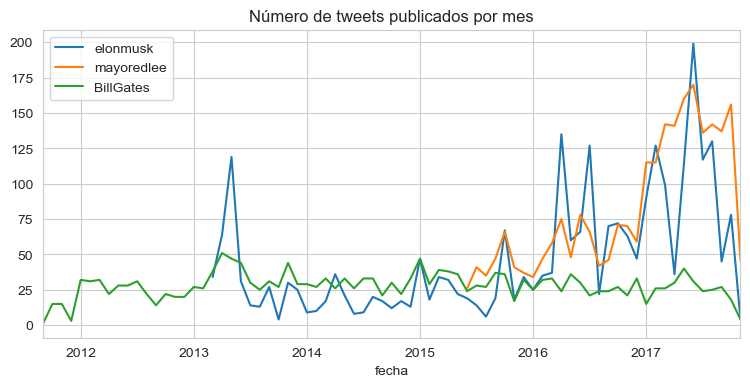

In [5]:
# Distribución temporal de los tweets
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

Puede observarse un perfil de actividad distinto para cada usuario. Bill Gates ha mantenido una actividad constante de en torno a 30 tweets por mes durante todo el periodo estudiado. Elon Musk muestra una actividad inicial por debajo de la de Bill Gates pero, a partir de febrero de 2016, incrementó notablemente el número de tweets publicados. Ed Lee tiene una actividad muy alta sobre todo en el periodo 2017. Debido a las limitaciones que impone Twitter en las recuperaciones, cuanto más activo es un usuario, menor es el intervalo de tiempo para el que se recuperan tweets. En el caso de Ed Lee, dado que publica con mucha más frecuencia que el resto, con la misma cantidad de tweets recuperados se abarca menos de la mitad del rango temporal que con los otros.

Limpieza y Tokenización

El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Existen múltiples librerías que automatizan en gran medida la limpieza y tokenización de texto, por ejemplo, la clase feature_extraction.text.CountVectorizer de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una función que, si bien está menos optimizada, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado.

In [6]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


La función limpiar_tokenizar() elimina el símbolo @ y # de las palabras a las que acompañan. En Twitter, los usuarios se identifican de esta forma, por lo que @ y # pertenecen al nombre. Aunque es importante tener en cuenta las eliminaciones del proceso de limpieza, el impacto en este caso no es demasiado alto, ya que, si un documento se caracteriza por tener la palabra #datascience, también será detectado fácilmente mediante la palabra datascience.

In [7]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


Gracias a la característica de los data.frame de pandas de poder contener cualquier tipo de elemento en sus columnas (siempre que sea el mismo para toda la columna), se puede almacenar el texto tokenizado. Cada elemento de la columna texto_tokenizado es una lista que contiene los tokens generados.

De nuevo matizar que, para casos productivos, es preferible emplear los tokenizadores de Scikit Learn, nltk o spaCy.

Análisis exploratorio

A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos...

In [8]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


Frecuencia de palabras

In [9]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [10]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

Aunque Elon Musk no es el que más palabras totales ha utilizado, bien porque ha publicado menos tweets o porque estos son más cortos, es el que más palabras distintas emplea.

Longitud media de tweets

In [11]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


El tipo de tweet de Bill Gates y Mayor Ed Lee es similar en cuanto a longitud media y desviación. Elon Musk alterna más entre tweets cortos y largos, siendo su media inferior a la de los otros dos.

Palabras más utilizadas por autor

In [13]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
    .count() \
    .reset_index(name='count') \
    .groupby('autor') \
    .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [25]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stopwords: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [26]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

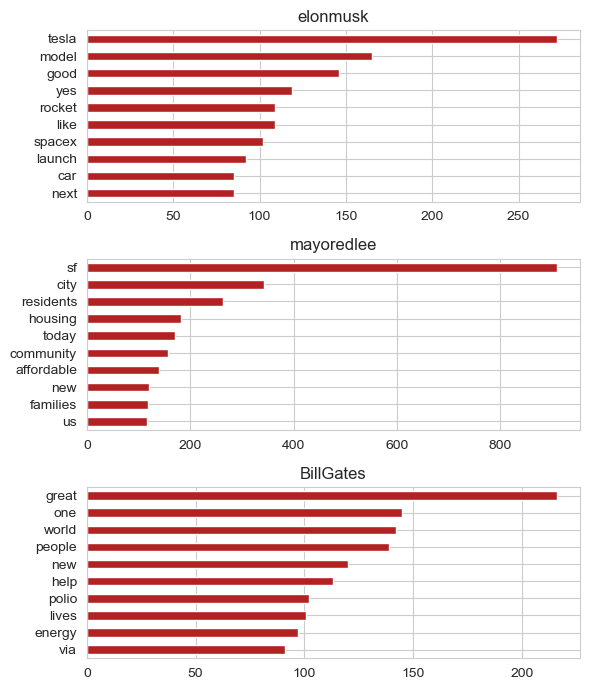

In [27]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

Los resultados obtenidos tienen sentido si ponemos en contexto la actividad profesional de los usuarios analizados. Mayor Ed Lee es alcalde de San Francisco (sf), por lo que sus tweets están relacionados con la ciudad, residentes, familias, casas... Elon Musk dirige varias empresas tecnológicas entre las que destacan Tesla y SpaceX, dedicadas a los coches y a la aeronáutica. Por último, Bill Gates, además de propietario de microsoft, dedica parte de su capital a fundaciones de ayuda, de ahí las palabras mundo, polio, ayuda...

Correlación entre autores

Una forma de cuantificar la similitud entre los perfiles de dos usuarios de Twitter es calculando la correlación en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tenderán a utilizar las mismas palabras y con frecuencias similares. La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlación se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [28]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
    .agg(["count"]).reset_index() \
    .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [29]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


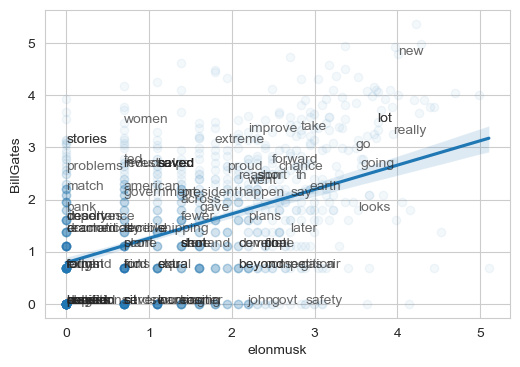

In [30]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elonmusk),
    y  = np.log(temp.BillGates),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.elonmusk[i]), np.log(temp.BillGates[i])),
        alpha = 0.7
    )

In [31]:
# Número de palabras comunes
# ==============================================================================
palabras_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
palabras_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
palabras_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Palabras comunes entre Elon Musk y Ed Lee: {len(palabras_elon.intersection(palabras_edlee))}")
print(f"Palabras comunes entre Elon Elon Musk y Bill Gates: {len(palabras_elon.intersection(palabras_bill))}")

Palabras comunes entre Elon Musk y Ed Lee: 1760
Palabras comunes entre Elon Elon Musk y Bill Gates: 1758


Aunque el número de palabras comunes entre Elon Musk y Bill Gates y entre Elon Musk y Ed Lee es similar, la correlación basada en su uso es mayor entre Elon Musk y Bill Gates. Esto tiene sentido si se contempla el hecho de que ambos trabajan como directivos de empresas tecnológicas.

Comparación en el uso de palabras

A continuación, se estudia qué palabras se utilizan de forma más diferenciada por cada usuario, es decir, palabras que utiliza mucho un autor y que no utiliza el otro. Una forma de hacer este análisis es mediante el log of odds ratio de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Elon Musk y Mayor Ed Lee.

log of odds ratio=log⎛⎝⎜[nk+1/N+1]Elon/[nk+1/N+1]Edd⎞⎠⎟

siendo  nk el número de veces que aparece el término k en los textos de cada autor y N el número total de términos de cada autor.

Para realizar este cálculo es necesario que, para todos los usuarios, se cuantifique la frecuencia de cada una de las palabras que aparecen en el conjunto de tweets, es decir, si un autor no ha utilizado una de las palabras que sí ha utilizado otro, debe aparecer esa palabra en su registro con frecuencia igual a cero. Existen varias formas de conseguir esto, una de ellas es pivotar y despivotar el dataframe sustituyendo los NaN por cero.

In [32]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
    .agg(["count"]).reset_index() \
    .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
    tweets_tidy.groupby('autor')['token'].count().rename('N'),
    how = 'left',
    on  = 'autor'
)

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                             "elonmusk",
                                             "mayoredlee"
                                             )

In [33]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,elonmusk,mayoredlee,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tesla,0.012569,0.000037,5.815040,5.815040,elonmusk
residents,0.000046,0.009934,-5.374162,5.374162,mayoredlee
yes,0.005525,0.000037,4.993060,4.993060,elonmusk
rocket,0.005064,0.000037,4.906049,4.906049,elonmusk
community,0.000046,0.005960,-4.863336,4.863336,mayoredlee
spacex,0.004742,0.000037,4.840297,4.840297,elonmusk
sf,0.000276,0.034112,-4.816117,4.816117,mayoredlee
falcon,0.003775,0.000037,4.612288,4.612288,elonmusk
landing,0.003039,0.000037,4.395223,4.395223,elonmusk


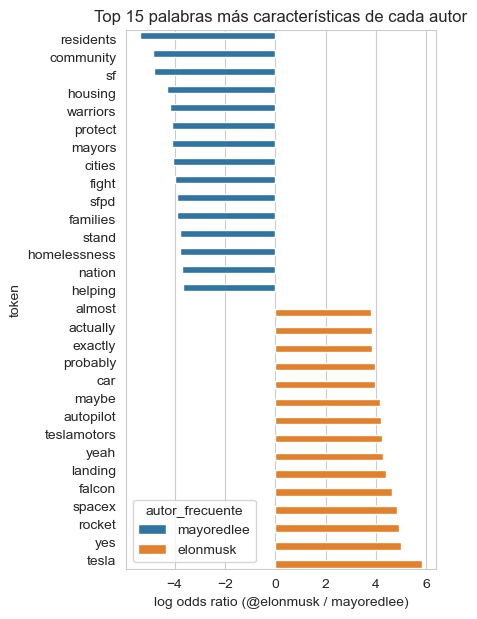

In [34]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
    .groupby('autor_frecuente') \
    .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
    .reset_index(drop=True) \
    .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

Estas palabras posiblemente tendrán mucho peso a la hora de clasificar los tweets.

Term Frequency e Inverse Document Frequency

Uno de los principales intereses en text mining, natural language processing e information retrieval es cuantificar la temática de un texto, así como la importancia de cada término que lo forma. Una manera sencilla de medir la importancia de un término dentro de un documento es utilizando la frecuencia con la que aparece (tf, term-frequency). Esta aproximación, aunque simple, tiene la limitación de atribuir mucha importancia a aquellas palabras que aparecen muchas veces aunque no aporten información selectiva. Por ejemplo, si la palabra matemáticas aparece 5 veces en un documento y la palabra página aparece 50, la segunda tendrá 10 veces más peso a pesar de que no aporte tanta información sobre la temática del documento. Para solucionar este problema se pueden ponderar los valores tf multiplicándolos por la inversa de la frecuencia con la que el término en cuestión aparece en el resto de documentos(idf). De esta forma, se consigue reducir el valor de aquellos términos que aparecen en muchos documentos y que, por lo tanto, no aportan información selectiva.

El estadístico tf-idf mide cómo de informativo es un término en un documento teniendo en cuenta la frecuencia con la que ese término aparece en otros documentos.



Term Frequency (tf)

tf (t, d)=nt / longitud d

donde  nt   es el número de veces que aparece el término  t en el documento  d.

Inverse Document Frequency

idf (t)=log(nd / n(d,t))

donde  nd   es el número total de documentos y  n(d,t) el número de documentos que contienen el término  t.

Estadístico tf-idf

tf-idf(t, d)=tf (t, d)∗idf (t)

En la práctica, para evitar problemas con el logaritmo cuando aparecen valores de 0, se emplea una versión corregida del  idf (t)
 . Esta es la versión implementada en Scikit Learn.

idf (t)=log1+n / d1+n(d,t) +1



En los siguientes apartados se muestra cómo calcular el valor tf-idf Sin embargo, en la práctica, es preferible utilizar implementaciones como TfidfVectorizer de Scikit Learn.

In [35]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
8158,3.546906e+17,bar,1,20,0.05
8159,3.546906e+17,barman,1,20,0.05
8164,3.546906e+17,says,1,20,0.05


In [36]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
50471,sf,914,2.061781
8724,city,355,3.007494
22823,great,327,3.089651


In [37]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1.195196e+17,efforts,1,13,0.076923,31,5.445624,0.418894
46,1.195196e+17,job,1,13,0.076923,36,5.296093,0.407392
229,1.195196e+17,nigeria,1,13,0.076923,10,6.577027,0.505925
239,1.195196e+17,phenomenal,1,13,0.076923,14,6.240554,0.480043
253,1.195196e+17,polio,1,13,0.076923,102,4.254639,0.327280


Puede observarse que para el primer tweet (id = 1.195196e+17), todos los términos que aparecen una vez, tienen el mismo valor de tf, sin embargo, dado que no todos los términos aparecen con la misma frecuencia en el conjunto de todos los tweets, la corrección de idf es distinta para cada uno.

De nuevo remarcar que, si bien se ha realizado el cálculo de forma manual con fines ilustrativos, en la práctica, es preferible utilizar implementaciones optimizadas como es el caso de la clase TfidfVectorizer de Scikit Learn.

Clasificación de tweets

Para poder aplicar algoritmos de clasificación a un texto, es necesario crear una representación numérica del mismo. Una de las formas más utilizadas se conoce como Bag of Words. Este método consiste en identificar el set formado por todas las palabras (tokens) que aparecen en el corpus, en este caso el conjunto de todos los tweets recuperados. Con este set se crea un espacio n-dimensional en el que cada dimensión (columna) es una palabra. Por último, se proyecta cada texto en ese espacio, asignando un valor para cada dimensión. En la mayoría de casos, el valor utilizado es el tf-idf.

En el siguiente apartado se construye un modelo de aprendizaje estadístico basado en máquinas de vector soporte (SVM) con el objetivo de predecir la autoría de los tweets. En concreto, se comparan los tweets de Elon Musk y Mayor Ed Lee.

Como modelo se emplea un SVM de Scikit-Learn. Para facilitar la obtención de la matriz TF-IDF se recurre a la clase TfidVectorized también de Scikit-Learn pero, en lugar de utilizar el tokenizador por defecto, se emplea el mismo definido en los apartados anteriores.

Train-Test

En todo proceso de aprendizaje estadístico es recomendable repartir las observaciones en un set de entrenamiento y otro de test. Esto permite evaluar la capacidad del modelo. Para este ejercicio se selecciona como test un 20% aleatorio de los tweets.

In [38]:
# Reparto train y test
# ==============================================================================
datos_X = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'texto']
datos_y = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123

)

Es importante verificar que la proporción de cada grupo es similar en el set de entrenamiento y en el de test.

In [39]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'elonmusk': 52.68292682926829, 'mayoredlee': 47.31707317073171}
{'elonmusk': 50.53658536585366, 'mayoredlee': 49.46341463414634}


Vectorización tf-idf

Empleando los tweets de entrenamiento se crea un matriz tf-idf en la que cada columna es un término, cada fila un documento y el valor de intersección el tf-idf correspondiente. Esta matriz representa el espacio n-dimensional en el que se proyecta cada tweet.

La clase TfidfVectorizer de Scikit Learn automatizan la creación de una matriz df-idf a partir de un corpus de documentos. Entre sus argumentos destaca:

encoding: el tipo de codificación del texto, por defecto es 'utf-8'.

strip_accents: eliminación de acentos sustituyendolos por la misma letra sin el acento. Por defecto se emplea el método ‘ascii’.

lowercase: convertir a minúsculas todo el texto.

tokenizer: en caso de querer pasar un tokenizador definido por el usuario o de otra librería.

analyzer: tipo de división que realiza el tokenizador. Por defecto separa por palabras ('word').

stop_words: lista de stopwords que se eliminan durante el tokenizado. Por defecto utiliza un listado para el inglés.

ngram_range: rango de n-gramas incluidos. Por ejemplo, (1, 2) significa que se incluyen unigramas (palabras individuales) y bigramas (pares de palabras) como tokens.

min_df: fracción o número de documentos en los que debe de aparecer como mínimo un término para no ser excluido en el tokenizado. Este filtrado es una forma de eliminar ruido del modelo.

In [40]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [41]:
stop_words = list(stopwords.words('english'))
# Se añade la stopword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))

In [42]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
    tokenizer  = limpiar_tokenizar,
    min_df     = 3,
    stop_words = stop_words
)
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function limpiar_tokenizar at 0x0000023502947670>)

A la hora de transformar los documentos de test, hay que proyectarlos en la misma matriz obtenida previamente con los documentos de entrenamiento. Esto es importante ya que, si en los documentos de test hay algún término que no aparece en los de entrenamiento o viceversa, las dimensiones de cada matriz no coinciden.

In [43]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

Una vez que el objeto TfidfVectorizer ha sido entrenado, se puede acceder a los tokens creados con el método get_feature_names().

In [44]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 2738
['aa', 'aapi', 'aaronpaul', 'able', 'abort', 'abt', 'ac', 'aca', 'accel', 'acceleration']


Modelo SVM lineal

Como modelo de predicción se emplea un SVM.

In [45]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [46]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
    estimator  = svm.SVC(kernel= "linear"),
    param_grid = param_grid,
    scoring    = 'accuracy',
    n_jobs     = -1,
    cv         = 5,
    verbose    = 0,
    return_train_score = True
)

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,0.967317,0.003123,0.997073,0.000366
5,0.278256,0.963902,0.001981,0.985244,0.000994
7,16.681005,0.959756,0.004154,0.998720,0.000122
8,129.154967,0.959024,0.005034,0.998780,0.000193
9,1000.0,0.959024,0.005034,0.998780,0.000193
4,0.035938,0.753902,0.013545,0.772683,0.006535
0,0.00001,0.526829,0.000000,0.526829,0.000000
1,0.000077,0.526829,0.000000,0.526829,0.000000
2,0.000599,0.526829,0.000000,0.526829,0.000000
3,0.004642,0.526829,0.000000,0.526829,0.000000


In [47]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2.154434690031882} : 0.9673170731707316 accuracy


In [48]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
      )
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Elon Musk", "Mayor Ed Lee"],
             index = ["Elon Musk", "Mayor Ed Lee"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 1025 clasificaciones: 21
% de error: 2.048780487804878

-------------------
Matriz de confusión
-------------------


,Elon Musk,Mayor Ed Lee
Elon Musk,512,6
Mayor Ed Lee,15,492


Empleando un modelo de SVM lineal con hiperparámetro  C=2.15
  se consigue un test error del 2.05%. Se trata de un porcentaje de error bastante bajo, aún así, explorando otros modelos como pueden ser SVM no lineales o Random Forest podrían alcanzarse mejores resultados.

Análisis de sentimientos

Una forma de analizar el sentimiento de un de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman. Esta no es la única forma de abordar el análisis de sentimientos, pero consigue un buen equilibrio entre complejidad y resultados.

Para llevar a cabo esta aproximación es necesario disponer de un diccionario en el que se asocie a cada palabra un sentimiento o nivel de sentimiento. A estos diccionarios también se les conoce como sentiment lexicon. Dos de los más utilizados son:

AFINN: en él, se asigna a cada palabra un valor entre -5 y 5, siendo -5 el máximo de negatividad y +5 el máximo de positividad. Se puede acceder al diccionario a través del repositorio https://github.com/fnielsen/afinn/tree/master/afinn/data.

Bing y Liu (http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar), donde las palabras están clasificadas como positivas o negativas.



In [49]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
    'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
    names = ['termino', 'sentimiento']
)
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


Sentimiento promedio de cada tweet

Al disponer de los datos en formato tidy (una palabra por fila), mediante un inner join se añade a cada palabra su sentimiento y se filtran automáticamente todas aquellas palabras para las que no hay información disponible.

In [50]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
    left     = tweets_tidy,
    right    = lexicon,
    left_on  = "token",
    right_on = "termino",
    how      = "inner"
)

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
    .groupby(["autor", "fecha", "id"]) \
    .sum().reset_index()
tweets_sentimientos.head()

,autor,fecha,id,sentimiento
0,BillGates,2011-09-29 21:11:15+00:00,1.195196e+17,6
1,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,-3
2,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,3
3,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,6
4,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,3


Tweets positivos, negativos y neutros

Se calcula el porcentaje de tweets positivos, negativos y neutros para cada autor.

In [51]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

BillGates
Positivos: 79.88
Neutros  : 4.59
Negativos: 15.52
 
elonmusk
Positivos: 73.14
Neutros  : 4.29
Negativos: 22.57
 
mayoredlee
Positivos: 80.73
Neutros  : 4.07
Negativos: 15.2
 


Los tres autores tienen un perfil muy similar. La gran mayoría de tweets son de tipo positivo. Este patrón es común en redes sociales, donde se suele participar mostrando aspectos o actividades positivas. Los usuarios no tienden a mostrar las cosas malas de sus vidas.

Evolución temporal

A continuación, se estudia cómo varía el sentimiento promedio de los tweets agrupados por intervalos de un mes para cada uno de los usuarios.

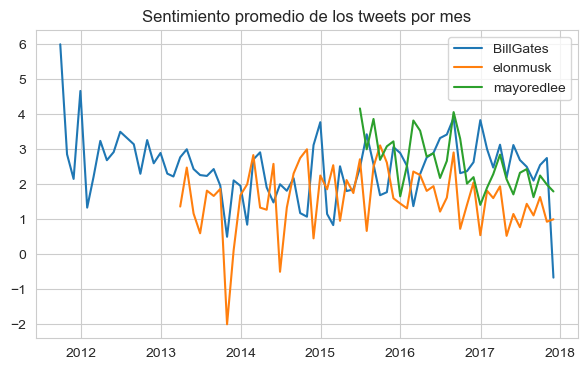

In [52]:
fig, ax = plt.subplots(figsize=(7, 4))

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();

La distribución del sentimiento promedio de los tweets se mantiene aproximadamente constante para los 3 usuarios. Existen ciertas oscilaciones, pero prácticamente la totalidad de ellas dentro del rango de sentimiento positivo.

In [54]:
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.6.2
nltk        3.7
numpy       1.21.5
pandas      1.4.4
scipy       1.7.3
seaborn     0.11.2
sinfo       0.3.4
sklearn     1.0.2
-----
IPython             7.31.1
jupyter_client      7.4.7
jupyter_core        4.11.2
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19044-SP0
8 logical CPU cores, Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
-----
Session information updated at 2023-04-25 11:

Este trabajo es realizado por José Ramó Iglesias Gamarra es licenciado con una licencia Creative Commons Attribution 4.0 International